In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
 

In [3]:
##parameters for training the model 
path = "mydata32" # folder with all the class folders
labelFile = 'label.csv' # file with all names of classes
batch_size_val= 50  # how many images to be processed together
steps_per_epoch_val= 500 #training samples divided by batch size (X-train/batch_size_val)
epochs_val=30  #30 iterations for all the training samples
imageDimesion = (32, 32, 3)#32 by 32 with 3 pixel channels r,g,b
testRatio = 0.5    # if 1000 images split will 500 for testing
validationRatio = 0.3 # if 1000 images 20% of remaining 800 will be 160 for validation

In [4]:
#storing the images and corressponding classnames in the array and converting them into numpy array

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))#subfolders are 0,1,2,3
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y) #pics inside the subfolder
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 4
Importing Classes.....
0 1 2 3  


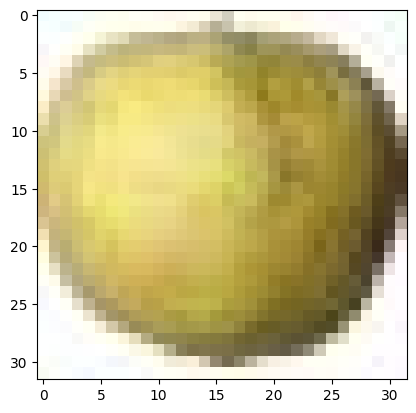

In [5]:
img = load_img("mydata32/0/0001_100 (1).jpg")
plt.imshow(img)
plt.axis("on")
plt.show()

In [6]:

#splitting of the data into training validation(validating over training data) and test data
#validation data provides first test againts unseen data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [7]:


print("Data Shapes")
print("Train",end = "");
print(X_train.shape,y_train.shape)
print("Validation",end = "");
print(X_validation.shape,y_validation.shape)
print("Test",end = "");
print(X_test.shape,y_test.shape)

Data Shapes
Train(2429, 32, 32, 3) (2429,)
Validation(1041, 32, 32, 3) (1041,)
Test(3470, 32, 32, 3) (3470,)


In [8]:
# TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:] == (imageDimesion)), " The dimesions of the Training images are wrong "
assert(X_validation.shape[1:] == (imageDimesion)), " The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:] == (imageDimesion)), " The dimesionas of the Test images are wrong"


In [9]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (4, 2) <class 'pandas.core.frame.DataFrame'>


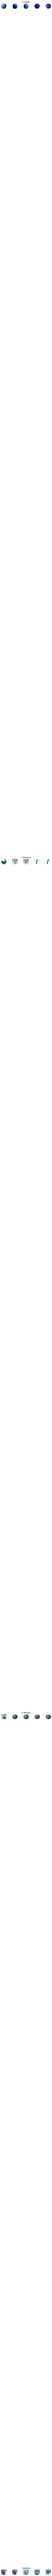

In [10]:
#show some samples of training data 
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))
            
            

[980, 583, 410, 456]


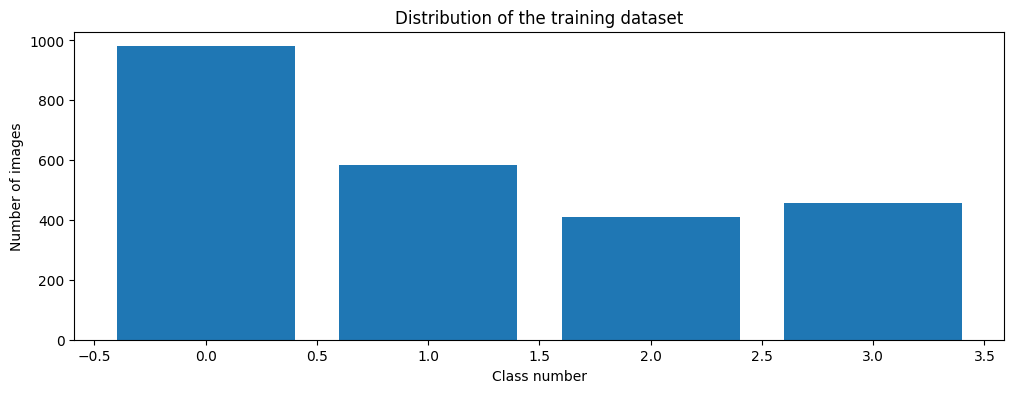

In [11]:
# NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [12]:
# PREPROCESSING THE IMAGES

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

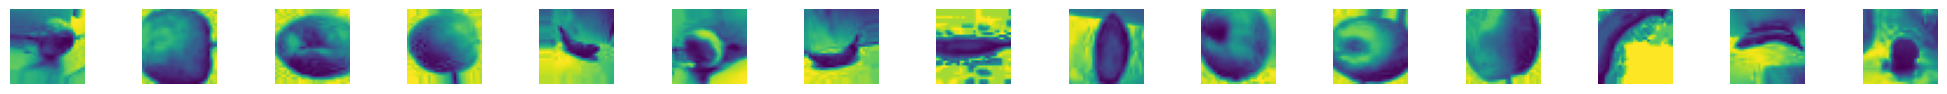

In [13]:
#AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES

dataGen.fit(X_train.reshape(2429, 32, 32, 1))
batches= dataGen.flow(X_train.reshape(2429, 32, 32, 1),y_train ,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesion[0], imageDimesion[1]))
    axs[i].axis('off')
plt.show()



In [14]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)


In [15]:
 def myModel():
    no_Of_Filters=60
    size_of_Filter=(5, 5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3, 3)
    size_of_pool=(2, 2)  # SCALE DOWN ALL FEATURE MAP TO GENRALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 1000   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesion[0], imageDimesion[1], 1), activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


#TRAIN
steps_per_epoch_val = len(X_train)//batch_size_val

validation_steps = len(X_test)//batch_size_val # if you have validation data 
model = myModel()
print(model.summary())
history= model.fit(X_train, y_train, batch_size=batch_size_val, steps_per_epoch=steps_per_epoch_val, epochs=epochs_val, validation_data=(X_validation,y_validation),shuffle=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

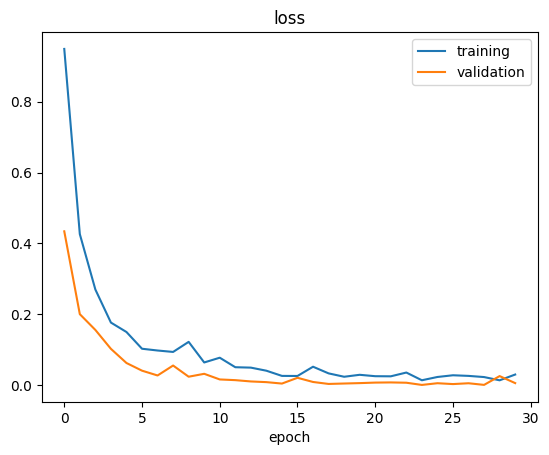

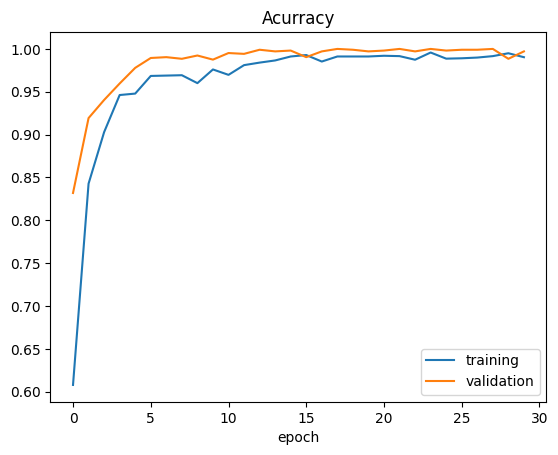

Test Score: 0.01452550943940878
Test Accuracy: 0.9951008558273315
training Score: 0.0027536700945347548
training Accuracy: 0.9991766214370728
validation Score: 0.00581098860129714
validation Accuracy: 0.9971181750297546


In [16]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1]) 


score2 =model.evaluate(X_train, y_train, verbose=0)
print('training Score:', score2[0])
print('training Accuracy:', score2[1]) 


score3 =model.evaluate(X_validation, y_validation, verbose=0)
print('validation Score:', score3[0])
print('validation Accuracy:', score3[1]) 

33/33 [==============================] - 2s 53ms/step


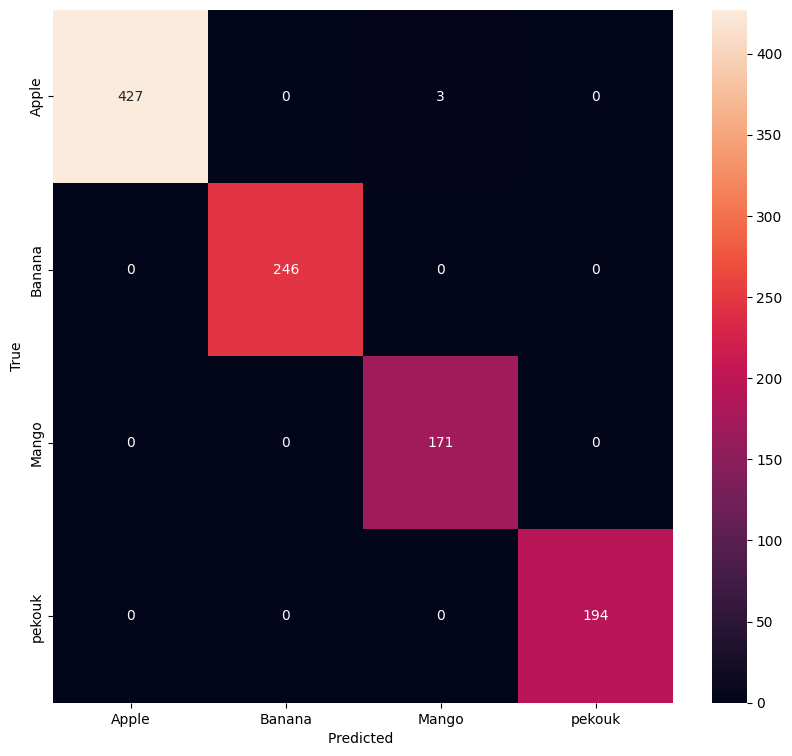

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

import seaborn as sns
#confusion matrix
y_pred=model.predict(X_validation)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_validation,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
fruit_names=["Apple","Banana", "Mango","pekouk"]


#confusion matrix to show results in terms of number of images 
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(conf_mat,annot=True, fmt='.0f')
ax.set_xticklabels(fruit_names)
ax.set_yticklabels(fruit_names)
ax.set_xlabel('Predicted ')
ax.set_ylabel('True')
plt.show()

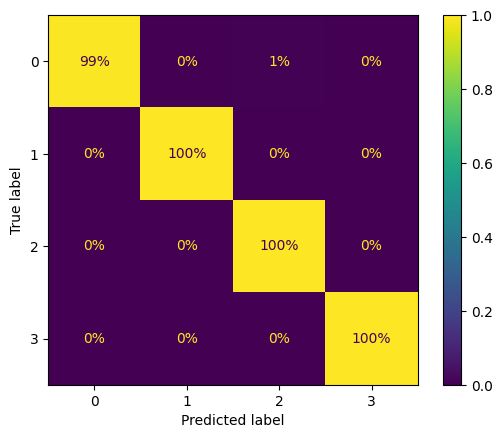

In [18]:


ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, normalize="true", values_format=".0%")
plt.show()



In [19]:
#predicting the fruit 
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img


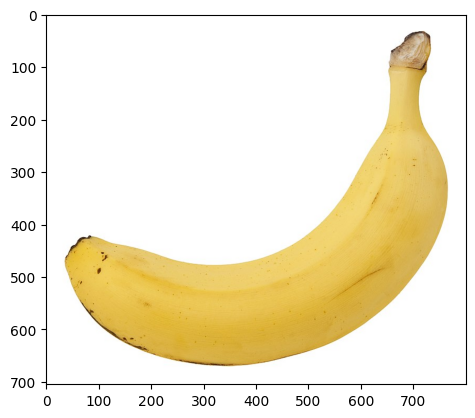

In [20]:
img= load_img("Banana-Single.jpg")
plt.imshow(img)

In [21]:
img = np.asarray(img )
img = cv2.resize(img, (32,32))
img = preprocessing(img)
img = img.reshape(1,32, 32, 1)

In [22]:
predictions = model.predict(img)
# classIndex = model.predict_classes(img) 
print(predictions)

y_predict = np.argmax(predictions, axis=-1)
print(y_predict)

1/1 [==============================] - 0s 31ms/step
[[4.5973411e-01 5.4011887e-01 1.0335098e-06 1.4604669e-04]]
[1]


In [23]:
def getClassName(classNo):
    if   classNo == 0: return 'Apple'
    elif classNo == 1: return 'Banana'
    elif classNo == 2: return 'Mango'
    elif classNo == 3: return 'Jicama'

print(getClassName(y_predict))

Banana


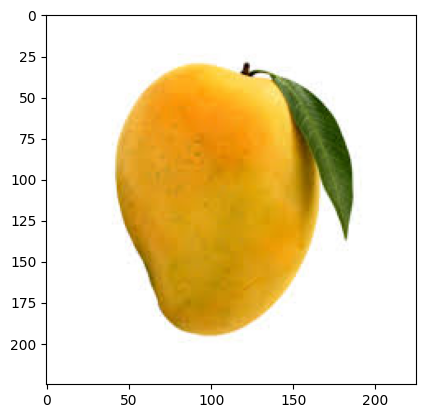

In [24]:
app= load_img("images.jpg")
plt.imshow(app)

In [25]:
app = np.asarray(app )
app = cv2.resize(app, (32,32))
app = preprocessing(app)
app = app.reshape(1,32, 32, 1)

In [26]:
predictions2 = model.predict(app)
# classIndex = model.predict_classes(img) 
print(predictions2)

y_predict2 = np.argmax(predictions2, axis=1)
print(y_predict2)

1/1 [==============================] - 0s 30ms/step
[[1.4417455e-13 4.6887990e-08 9.9948066e-01 5.1929342e-04]]
[2]


In [27]:


print(getClassName(y_predict2))

Mango


In [28]:
pickle_out= open("fourth.p","wb")  # wb = WRITE BYTE
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-07 19:34:56         4746
metadata.json                                  2023-03-07 19:34:56           64
variables.h5                                   2023-03-07 19:34:56      243761

-1